# Analyzing the Kickstarter Dataset
Goal of this notebook is to generate new features using the given ones to find correlation between features and the success rate of the kickstarter projects

# **Loading necessary libraries and the data**

In [340]:

from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn import metrics
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
data = pd.read_csv('../input/kickstarter-projects/ks-projects-201801.csv',
                 parse_dates=['deadline', 'launched'])
#Printing kickstarter 
list(data.state.unique())

['failed', 'canceled', 'successful', 'live', 'undefined', 'suspended']

There are 6 different states for projects, we are not interested in "live" projects for our analysis (they are yet to be labeled as successful or failed)

# Manipulating the data to give it more meaning

Grouping projects into Successful and Unsuccessful projects

Dropping live projects to focus on the finished projects

In [341]:

data = data.query('state != "live"')
data = data.assign(isSuccessful = (data['state']=='successful').astype(int))

## Calculating the time from launch until deadline
Idea is to find a correlation between life time of the project and their success rate

In [342]:
data = data.assign(lhour=data.launched.dt.hour,
               lday=data.launched.dt.day,
               lmonth=data.launched.dt.month,
               lyear=data.launched.dt.year)

### Kickstarter is founded in 2009
This means any project launched before 28.04.2009(DD/MM/YYYY, sorry I don't use weird date formats) will be dropped.

In [343]:
data = data[(data['launched'] >= '2009-04-28')]

In [344]:
data = data.assign(dhour=data.deadline.dt.hour,
               dday=data.deadline.dt.day,
               dmonth=data.deadline.dt.month,
               dyear=data.deadline.dt.year)

In [345]:
data = data.assign(total_year= data.dyear-data.lyear)
data = data.assign(total_month = data.total_year*12 + (data.dmonth-data.lmonth))
data = data.assign(total_day = data.total_month * 30 + (data.dday - data.lday))
data = data.assign(total_hour = data.total_day * 24 + (data.dhour - data.lhour))

## Can you have negative lifespan?
No. Then remove it.

In [346]:
data = data.query('total_hour >= 0')
data

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,...,lmonth,lyear,dhour,dday,dmonth,dyear,total_year,total_month,total_day,total_hour
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,...,8,2015,0,9,10,2015,0,2,58,1380
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,...,9,2017,0,1,11,2017,0,2,59,1412
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,...,1,2013,0,26,2,2013,0,1,44,1056
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,...,3,2012,0,16,4,2012,0,1,29,693
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,...,7,2015,0,29,8,2015,0,1,55,1312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378656,999976400,ChknTruk Nationwide Charity Drive 2014 (Canceled),Documentary,Film & Video,USD,2014-10-17,50000.0,2014-09-17 02:35:30,25.0,canceled,...,9,2014,0,17,10,2014,0,1,30,718
378657,999977640,The Tribe,Narrative Film,Film & Video,USD,2011-07-19,1500.0,2011-06-22 03:35:14,155.0,failed,...,6,2011,0,19,7,2011,0,1,27,645
378658,999986353,Walls of Remedy- New lesbian Romantic Comedy f...,Narrative Film,Film & Video,USD,2010-08-16,15000.0,2010-07-01 19:40:30,20.0,failed,...,7,2010,0,16,8,2010,0,1,45,1061
378659,999987933,BioDefense Education Kit,Technology,Technology,USD,2016-02-13,15000.0,2016-01-13 18:13:53,200.0,failed,...,1,2016,0,13,2,2016,0,1,30,702


## Adding a new column to turn "goal" data into categorical data
Turning "goal" and "backers" into categorical data helps us to analyze their effects on the success rate with ease because we will have a more generic opinion about them.
For example we could have two projects with just 1 dollar goal difference, this small change could feint our model into making wrong decisions and could lead to some over-fitting problems. Grouping numeric features with high range and non-uniform distribution will lead to clear understanding of their effects on success rate.

Selecting 30th, 60th and 90th percentiles to let us fit our numeric daha into categories.
Any value which is lower  from 30th percentile of the values will be labeled as "low"
And value which is between 30th and 60th percentile of our data will be labeled as "medium"
And value which have between 60th and 90th percentile of our data will be labeled as "high"
And any value higher than this will be labeled as "extreme"

### Changing percentiles and creating more labels could lead to better predictions

In [347]:
low = data['goal'].quantile(0.3)
mid = data['goal'].quantile(0.6)
high = data['goal'].quantile(0.9)

conditions = [(data['goal']<low),((data['goal']>=low) & (data['goal']<mid)),((data['goal']>=mid) & (data['goal']<high)),(data['goal']>=high)]
tags = ['t0_low', 't1_medium','t2_high','t3_extreme']

data = data.assign(categorical_goal = np.select(conditions,tags))


## Adding another column to turn "backers" into categorical data

In [348]:
low = data['backers'].quantile(0.3)
mid = data['backers'].quantile(0.6)
high = data['backers'].quantile(0.9)


conditions = [(data['backers']<low),((data['backers']>=low) & (data['backers']<mid)),((data['backers']>=mid) & (data['backers']<high)),(data['backers']>=high)]
tags = ['t0_low', 't1_medium','t2_high','t3_extreme']

data = data.assign(categorical_backers = np.select(conditions,tags))

data.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,...,dhour,dday,dmonth,dyear,total_year,total_month,total_day,total_hour,categorical_goal,categorical_backers
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,...,0,9,10,2015,0,2,58,1380,t0_low,t0_low
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,...,0,1,11,2017,0,2,59,1412,t2_high,t1_medium
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,...,0,26,2,2013,0,1,44,1056,t2_high,t1_medium
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,...,0,16,4,2012,0,1,29,693,t1_medium,t0_low
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,...,0,29,8,2015,0,1,55,1312,t2_high,t1_medium


> # Getting rid of some columns which is not relevant

- "Name" of the project _could_ have a effect on the success of the project but it would need high resources to identify (NLP/semantic analysis)
- "Goal" will be changed with "categorical_goal" so it is dropped.
- "Backers" will be changed with "categorical_backers" so it is dropped.
- Any date info will be changed with lifetime of the project so they are dropped.
- Total pledged money means success for finished projects but it can be used to make predictions about ongoing projects, which is not our case

In [349]:
groupableData = data.drop(columns = ['ID', 'name','goal','backers', 'deadline','dyear','lyear','dmonth','lmonth','dday','lday','dhour','lhour','launched','usd_goal_real','pledged','state','usd_pledged_real','usd pledged'])
groupableData

,category,main_category,currency,country,isSuccessful,total_year,total_month,total_day,total_hour,categorical_goal,categorical_backers
0,Poetry,Publishing,GBP,GB,0,0,2,58,1380,t0_low,t0_low
1,Narrative Film,Film & Video,USD,US,0,0,2,59,1412,t2_high,t1_medium
2,Narrative Film,Film & Video,USD,US,0,0,1,44,1056,t2_high,t1_medium
3,Music,Music,USD,US,0,0,1,29,693,t1_medium,t0_low
4,Film & Video,Film & Video,USD,US,0,0,1,55,1312,t2_high,t1_medium
...,...,...,...,...,...,...,...,...,...,...,...
378656,Documentary,Film & Video,USD,US,0,0,1,30,718,t3_extreme,t0_low
378657,Narrative Film,Film & Video,USD,US,0,0,1,27,645,t0_low,t1_medium
378658,Narrative Film,Film & Video,USD,US,0,0,1,45,1061,t2_high,t0_low
378659,Technology,Technology,USD,US,0,0,1,30,702,t2_high,t1_medium


### Checking which main categories are more likely to succeed

As it can be observed below, projects related to entertaintment have higher chances to succeed.

In [350]:
mainCategorySuccess = groupableData[['main_category','isSuccessful']]
mainCategorySuccess = mainCategorySuccess.groupby(['main_category']).mean().sort_values(by=['isSuccessful'], ascending = False)
mainCategorySuccess

,isSuccessful
main_category,
Dance,0.623467
Theater,0.601049
Comics,0.543796
Music,0.468597
Art,0.411668
Film & Video,0.373486
Games,0.358230
Design,0.354455
Publishing,0.310810


### Checking which categories are more likely to succeed

Data below somewhat contradict our main categories. This could help us to define some feature which we could not define only with our main categories.

In [351]:
categorySuccess = groupableData[['category','isSuccessful']]
categorySuccess = categorySuccess.groupby(['category']).mean().sort_values(by=['isSuccessful'], ascending = False)
categorySuccess

,isSuccessful
category,
Chiptune,0.771429
Residencies,0.724638
Anthologies,0.672258
Dance,0.665516
Letterpress,0.645833
...,...
Software,0.122638
Video,0.119718
Web,0.086914


### Is Currency relevant to success?

Some currencies have higher chances of success but does this mean anything?

Currencies like Euro and USD are valid in wide regions, which does not tell much, we could go into a little bit more detail without forgetting about currencies

In [352]:
currencySuccess = groupableData[['currency','isSuccessful']]
currencySuccess = currencySuccess.groupby(['currency']).mean()
currencySuccess

,isSuccessful
currency,
AUD,0.255203
CAD,0.278913
CHF,0.248340
DKK,0.325247
EUR,0.227337
GBP,0.356866
HKD,0.370497
JPY,0.225806
MXN,0.240729


### What about countries?

Some countries in EU-Zone have higher tendency to provide/get support for kickstarter projects than others

In [353]:
countrySuccess = groupableData[['country','isSuccessful']]
countrySuccess = countrySuccess.groupby(['country']).mean()
countrySuccess

,isSuccessful
country,
AT,0.183849
AU,0.258721
BE,0.251240
CA,0.282637
CH,0.250670
DE,0.228760
DK,0.328168
ES,0.221223
FR,0.314513


### Setting up high goals is a good thing?

There is a obvious negative correlation between amount of cash aimed and success rate. So don't be too _greedy_ when creating a kickstarter project.

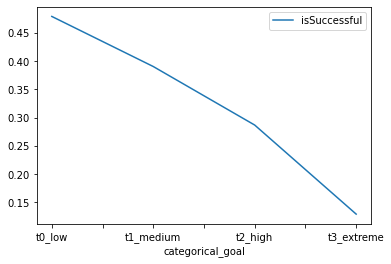

In [354]:
goalSuccess = groupableData[['categorical_goal','isSuccessful']]
goalSuccess = goalSuccess.groupby(['categorical_goal']).mean()
goalSuccess.plot()

### Quantity > Quality

A lot of people giving some money is better than some people giving alot of money. Because people attract more people.

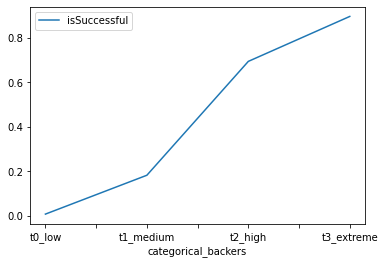

In [355]:
backerSuccess = groupableData[['categorical_backers','isSuccessful']]
backerSuccess = backerSuccess.groupby(['categorical_backers']).mean()
backerSuccess.plot()

### Plotting success rate related to total time passed

### Will I succeed after 40 years?
No.

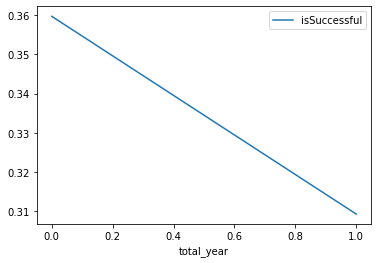

In [356]:
yearSuccess = groupableData[['total_year','isSuccessful']]
yearSuccess = yearSuccess.groupby(['total_year']).mean()
yearSuccess.plot()

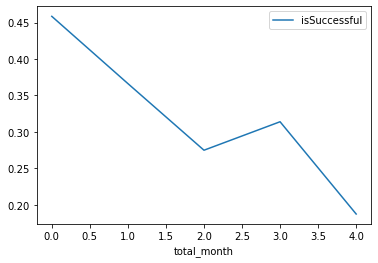

In [357]:
monthSuccess = groupableData[['total_month','isSuccessful']]
monthSuccess = monthSuccess.groupby(['total_month']).mean()
monthSuccess.plot()

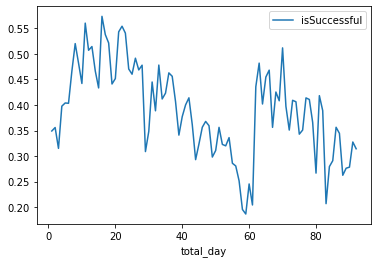

In [358]:
daySuccess = groupableData[['total_day','isSuccessful']]
daySuccess = daySuccess.groupby(['total_day']).mean()
daySuccess.plot()

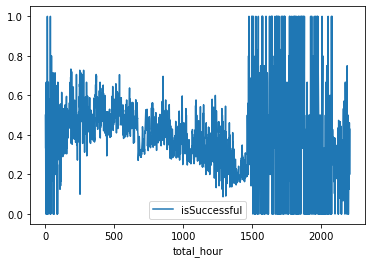

In [359]:
hourSuccess = groupableData[['total_hour','isSuccessful']]
hourSuccess = hourSuccess.groupby(['total_hour']).mean()
hourSuccess.plot()

# Encoding categorical data

In [360]:
encoder = LabelEncoder()
data = groupableData.apply(encoder.fit_transform)

encoded

,category,main_category,currency,country,isSuccessful,hour,day,month,year,categorical_goal,categorical_backers
0,108,12,5,9,0,12,10,7,7,0,0
1,93,6,13,22,0,4,1,8,9,2,1
2,93,6,13,22,0,0,11,0,5,2,1
3,90,10,13,22,0,3,16,2,4,1,0
4,55,6,13,22,0,8,3,6,7,2,1
...,...,...,...,...,...,...,...,...,...,...,...
378656,39,6,13,22,0,2,16,8,6,3,0
378657,93,6,13,22,0,3,21,5,3,0,1
378658,93,6,13,22,0,19,0,6,2,2,0
378659,138,13,13,22,0,18,12,0,8,2,1


# Splitting data into test, train, validation sets

In [361]:
frac = 0.1
size = int(len(data)*frac)

trainSet = data[:-2*size]
validationSet = data[-2*size: -size]
testSet = data[-size:]

### Training a model

In [362]:
features = trainSet.columns.drop('isSuccessful')

dtrain = lgb.Dataset(trainSet[features], label=trainSet['isSuccessful'])
dvalid = lgb.Dataset(validationSet[features], label=validationSet['isSuccessful'])

param = {'num_leaves': 64, 'objective': 'binary'}
param['metric'] = 'auc'
num_round = 1000
bst = lgb.train(param, dtrain, num_round, valid_sets=[dvalid], early_stopping_rounds=10, verbose_eval=False)

# Make predictions


In [363]:
ypred = bst.predict(testSet[features])
score = metrics.roc_auc_score(testSet['isSuccessful'], ypred)

print(f"Test AUC score: {score}")

Test AUC score: 0.9570498031623396
